In [2]:
from __future__ import absolute_import, division, print_function

!pip install tensorflow-gpu==2.0.0-alpha0
import tensorflow as tf

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time
import nltk
nltk.download('punkt')
import pickle

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
tf.__version__

'2.0.0-alpha0'

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ." 
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    
    w = w.rstrip().strip()
    
    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

In [0]:
f_en = open('/content/gdrive/My' + ' ' + 'Drive/Assignments_Sem2/NLU/assignment_2/wmt15-de-en/europarl-v7.de-en.en', 'r')
en0 = [preprocess_sentence(e) for e in f_en]
f_de = open('/content/gdrive/My' + ' ' + 'Drive/Assignments_Sem2/NLU/assignment_2/wmt15-de-en/europarl-v7.de-en.de', 'r')
de0 = [preprocess_sentence(e) for e in f_de]

In [0]:
print(len(en0))
print(de0[1:3])
test = " ".join(de0[1:3])
print(test)

1920209
['<start> ich erklare die am freitag , dem . dezember unterbrochene sitzungsperiode des europaischen parlaments fur wiederaufgenommen , wunsche ihnen nochmals alles gute zum jahreswechsel und hoffe , da sie schone ferien hatten . <end>', '<start> wie sie feststellen konnten , ist der gefurchtete millenium bug nicht eingetreten . doch sind burger einiger unserer mitgliedstaaten opfer von schrecklichen naturkatastrophen geworden . <end>']
<start> ich erklare die am freitag , dem . dezember unterbrochene sitzungsperiode des europaischen parlaments fur wiederaufgenommen , wunsche ihnen nochmals alles gute zum jahreswechsel und hoffe , da sie schone ferien hatten . <end> <start> wie sie feststellen konnten , ist der gefurchtete millenium bug nicht eingetreten . doch sind burger einiger unserer mitgliedstaaten opfer von schrecklichen naturkatastrophen geworden . <end>


In [0]:
import nltk
from nltk.probability import FreqDist
en_corpus = " ".join(en0)
de_corpus = " ".join(de0)

words = nltk.tokenize.word_tokenize(en_corpus)
fdist_en = FreqDist(words)
en_top = fdist_en.most_common(30000)

words = nltk.tokenize.word_tokenize(de_corpus)
fdist_de = FreqDist(words)
de_top = fdist_de.most_common(30000)

In [0]:
en_words = [e[0] for e in (en_top)]
de_words = [s[0] for s in (de_top)]
print(en_words[1:15])
print(de_words[1:15])

['>', 'the', ',', 'end', 'start', '.', 'of', 'to', 'and', 'in', 'that', 'a', 'is', 'for']
['>', ',', '.', 'die', 'end', 'start', 'der', 'und', 'in', 'zu', 'den', 'wir', 'ich', 'fur']


In [0]:
en = list()
de = list()
for i in range(len(en0)):
  en_ = en0[i].split(' ')
  for j in range(len(en_)):
    if en_[j] in en_words or en_[j]=='<start>' or en_[j]=='<end>':
      temp = 2
    else:
      en_[j] = 'UNK'
  en_ = ' '.join(en_)
  en.append(en_)
  
  
  de_ = de0[i].split(' ')
  for j in range(len(de_)):
    if de_[j] in de_words or de_[j]=='<start>' or de_[j]=='<end>':
      temp = 2
    else:
       de_[j] = 'UNK'
  de_ = ' '.join(de_)
  de.append(de_)

In [0]:
print(en[12])
print(de[100])

<start> if the house agrees , i shall do as mr evans has suggested . <end>
<start> jetzt mochte ich zur sache selbst etwas sagen . <end>


In [0]:
pickle.dump(en, open('/content/gdrive/My' + ' ' + 'Drive/Assignments_Sem2/NLU/assignment_2/pickle_europarl-v7.de-en.en', 'wb'))
pickle.dump(de, open('/content/gdrive/My' + ' ' + 'Drive/Assignments_Sem2/NLU/assignment_2/pickle_europarl-v7.de-en.de', 'wb'))

In [0]:
en = pickle.load(open('/content/gdrive/My' + ' ' + 'Drive/Assignments_Sem2/NLU/assignment_2/pickle_europarl-v7.de-en.en', 'rb'))
de = pickle.load(open('/content/gdrive/My' + ' ' + 'Drive/Assignments_Sem2/NLU/assignment_2/pickle_europarl-v7.de-en.de', 'rb'))

In [7]:
print(en[1])
print(de[1])

<start> i declare resumed the session of the european parliament adjourned on friday december , and i would like once again to wish you a happy new year in the hope that you enjoyed a pleasant festive period . <end>
<start> ich erklare die am freitag , dem . dezember unterbrochene sitzungsperiode des europaischen parlaments fur wiederaufgenommen , wunsche ihnen nochmals alles gute zum jahreswechsel und hoffe , da sie schone ferien hatten . <end>


In [0]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [0]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)
  
  tensor = lang_tokenizer.texts_to_sequences(lang)
  
  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, maxlen =20,padding='post')
  
  return tensor, lang_tokenizer

In [0]:
def load_dataset():

    input_tensor, inp_lang_tokenizer = tokenize(en)
    target_tensor, targ_lang_tokenizer = tokenize(de)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [0]:
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset()

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

In [13]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.1)
# Show length
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val)

(1728188, 1728188, 192021, 192021)

In [0]:
def inp_convert(lang, tensor):
  s = ''
  for t in tensor:
    if (t!=3 and t!=4 and t!=0):
      s = s + ' ' + lang.index_word[t]
    else:
      temp = 2
      #print ("%d ----> %s" % (t, lang.index_word[t]))
  return s[1:].split(' ')

In [0]:
def tar_convert(lang, tensor):
  s = ''
  for t in tensor:
    if (t!=4 and t!=0):
      s = s + ' ' + lang.index_word[t]
    else:
      temp = 2
      #print ("%d ----> %s" % (t, lang.index_word[t]))
  return s[1:].split(' ')

In [16]:
#inp_lang.index_word[0]
print ("Input Language; index to word mapping")
s1 = (inp_convert(inp_lang, input_tensor_train[0]))
print(s1)
print ("Target Language; index to word mapping")
s2 = (tar_convert(targ_lang, target_tensor_train[0]))
print(s2)

Input Language; index to word mapping
['thank', 'you', ',', 'commissioner', '.']
Target Language; index to word mapping
['vielen', 'dank', ',', 'frau', 'kommissarin', '.', '<end>']


In [0]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 128
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 128
units = 512
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [18]:
example_input_batch, example_target_batch = next(iter(dataset))
print(example_input_batch.shape, example_target_batch.shape)
print(vocab_inp_size)
print(vocab_tar_size)

(128, 20) (128, 20)
30002
30002


In [0]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units, 
                                   return_sequences=True, 
                                   return_state=True, 
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    #print(x.shape)
    x = self.embedding(x)
    #print(x.shape)
    output, state = self.gru(x, initial_state = hidden)        
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [20]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (128, 20, 512)
Encoder Hidden state shape: (batch size, units) (128, 512)


In [0]:
class SelfAttention(tf.keras.Model):
  def __init__(self, units):
    super(SelfAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)
  
  def call(self, query, values):
    # hidden shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # we are doing this to perform addition to calculate the score
    hidden_with_time_axis = tf.expand_dims(query, 1)
    #print('shape of query is {}'.format(query.shape))
    #print('shape of hidden_with_time_axis is {}'.format(hidden_with_time_axis.shape))
    #print('shape of values {}'.format(values.shape))
    #print('shape of self.W1(values) is {}'.format(self.W1(values).shape))
    #print('shape of self.W2(hidden_with_time_axis) is {}'.format(self.W2(hidden_with_time_axis).shape))

    # score shape == (batch_size, max_length, hidden_size)
    score = self.V(tf.nn.tanh(
        self.W1(values)))
    
    #print('shape of score is {}'.format(score.shape))

    # attention_weights shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    attention_weights = tf.nn.softmax(score, axis=1)
    #print('shape of attention_weights {}'.format(attention_weights.shape))
    

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)
    #print(context_vector.shape)
    
    return context_vector, attention_weights

In [22]:
attention_layer = SelfAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (128, 512)
Attention weights shape: (batch_size, sequence_length, 1) (128, 20, 1)


In [0]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units, 
                                   return_sequences=True, 
                                   return_state=True, 
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = SelfAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)
    #print(context_vector.shape)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    #print(x.shape)
    x = self.embedding(x)
    #print(x.shape)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    #print(x.shape)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)
    #print(output.shape)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))
    #print(output.shape)

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [37]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)), 
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (128, 30002)


In [0]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  
  return tf.reduce_mean(loss_)

In [0]:
checkpoint_dir = '/content/gdrive/My' + ' ' + 'Drive/Assignments_Sem2/NLU/assignment_2/self_attention/training_checkpoints_2'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [0]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0
        
  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)       

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))
  
  return batch_loss

In [62]:
EPOCHS = 4

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
        print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                     batch,
                                                     batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 1 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)
    #pickle.dump(optimizer, open('/content/gdrive/My' + ' ' + 'Drive/Assignments_Sem2/NLU/assignment_2/pickle_optimizer', 'wb'))
    #pickle.dump(encoder, open('/content/gdrive/My' + ' ' + 'Drive/Assignments_Sem2/NLU/assignment_2/pickle_encoder', 'wb'))
    #pickle.dump(decoder, open('/content/gdrive/My' + ' ' + 'Drive/Assignments_Sem2/NLU/assignment_2/pickle_decoder', 'wb'))
    

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.2147
Epoch 1 Batch 100 Loss 2.1615
Epoch 1 Batch 200 Loss 2.2526
Epoch 1 Batch 300 Loss 2.1744
Epoch 1 Batch 400 Loss 2.1198
Epoch 1 Batch 500 Loss 2.1519
Epoch 1 Batch 600 Loss 2.4807
Epoch 1 Batch 700 Loss 2.3882
Epoch 1 Batch 800 Loss 2.4874
Epoch 1 Batch 900 Loss 2.4266
Epoch 1 Batch 1000 Loss 2.4362
Epoch 1 Batch 1100 Loss 2.4694
Epoch 1 Batch 1200 Loss 2.5865
Epoch 1 Batch 1300 Loss 2.5484
Epoch 1 Batch 1400 Loss 2.1836
Epoch 1 Batch 1500 Loss 2.4317
Epoch 1 Batch 1600 Loss 2.4934
Epoch 1 Batch 1700 Loss 2.3282
Epoch 1 Batch 1800 Loss 2.4265
Epoch 1 Batch 1900 Loss 2.3805
Epoch 1 Batch 2000 Loss 2.4224
Epoch 1 Batch 2100 Loss 2.4073
Epoch 1 Batch 2200 Loss 2.4885
Epoch 1 Batch 2300 Loss 2.4250
Epoch 1 Batch 2400 Loss 2.4107
Epoch 1 Batch 2500 Loss 2.2168
Epoch 1 Batch 2600 Loss 2.2671
Epoch 1 Batch 2700 Loss 2.3467
Epoch 1 Batch 2800 Loss 2.3105
Epoch 1 Batch 2900 Loss 2.3920
Epoch 1 Batch 3000 Loss 2.5334
Epoch 1 Batch 3100 Loss 2.3760
Epoch 1 Batch 3200 L

KeyboardInterrupt: ignored

In [0]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    
    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], 
                                                           maxlen=max_length_inp, 
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)
    
    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)
    
    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input, 
                                                             dec_hidden, 
                                                             enc_out)
        
        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot
        
        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [0]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    
    fontdict = {'fontsize': 10}
    
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
    #plt.savefig('/content/gdrive/My' + ' ' + 'Drive/Assignments_Sem2/NLU/assignment_2/self_attention/fig3_self_attention')
    plt.show()

In [0]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)
        
    print('Input: %s' % (sentence).encode('utf-8'))
    print('Predicted translation: {}'.format(result))
    
    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))
    return result

In [0]:
def translate_tmp(sentence):
    result, sentence, attention_plot = evaluate(sentence)
        
    #print('Input: %s' % (sentence).encode('utf-8'))
    #print('Predicted translation: {}'.format(result))
    
    #attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    #plot_attention(attention_plot, sentence.split(' '), result.split(' '))
    return result

In [47]:
# restoring the latest checkpoint in checkpoint_dir
#checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: b'<start> the problems with fishmeal lie elsewhere . <end>'
Predicted translation: die fischmehl . <end> 


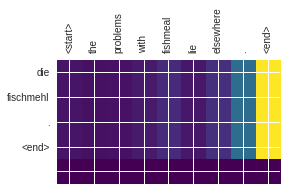

die fischmehl . <end> 


In [101]:
#s = translate(' '.join(inp_convert(inp_lang, input_tensor_train[25]))).split(' ')
s = translate('the problems with fishmeal lie elsewhere .')
print(s)

In [0]:
ref = list()
for i in range(1000):
  ref_tmp = list()
  ref_tmp.append(tar_convert(targ_lang, target_tensor_val[i]))
  ref.append(ref_tmp)
  
cand = list()
for i in range(1000):
  s = translate_tmp(' '.join(inp_convert(inp_lang, input_tensor_val[i]))).split(' ')
  cand.append(s)

In [0]:
import pickle
pickle.dump(cand, open('/content/gdrive/My' + ' ' + 'Drive/Assignments_Sem2/NLU/assignment_2/bahadanau_attention/pickle_candidate_translation', 'wb'))
pickle.dump(ref, open('/content/gdrive/My' + ' ' + 'Drive/Assignments_Sem2/NLU/assignment_2/bahadanau_attention/pickle_reference_translation', 'wb'))

In [96]:
print(ref[0:5])
print(cand[0:5])
print(len(ref))
print(len(cand))

[[['ich', 'teile', 'ihnen', 'mit', ',', 'da', 'ich', 'gema', 'artikel', 'absatz', 'der', 'geschaftsordnung', 'einen', 'entschlie', 'ungsantrag', 'erhalten', 'habe', '.', '<end>']], [['es', 'gibt', 'ganz', 'konkrete', 'falle', 'von', 'kleinkinder', 'unk', '.', '<end>']], [['vielen', 'dank', ',', 'herr', 'kommissar', '!', '<end>']], [['die', 'arbeitslosigkeit', 'in', 'der', 'eu', 'wird', 'ein', 'immer', 'unk', 'problem', '.', '<end>']], [['konnte', 'die', 'kommission', 'bitte', 'alsbald', 'dieser', 'sache', 'nachgehen', '?', '<end>']]]
[['einen', 'entschlie', 'ungsantrag', 'eingereicht', 'wurde', '.', '<end>', ''], ['es', 'gab', 'es', 'gab', 'es', 'gab', 'es', 'gab', 'es', 'gab', 'es', 'gab', 'es', 'gab', 'es', 'gab', 'es', 'gab', 'es', 'gab', ''], ['vielen', 'dank', ',', 'herr', 'kommissar', '.', '<end>', ''], ['die', 'arbeitslosigkeit', 'wird', 'immer', 'ein', 'wachsendes', 'problem', '.', '<end>', ''], ['kann', 'die', 'kommission', 'die', 'kommission', 'die', 'kommission', 'die', 'kom

In [97]:
# two references for one document
from nltk.translate.bleu_score import corpus_bleu
#references = [[['this', 'is', 'a', 'test'], ['this', 'is' 'test']]]
#candidates = [['this', 'is', 'a', 'test']]
score = corpus_bleu(ref, cand)
print(score)

0.06317464224006847


In [57]:
s = ['nn','dgc']
s = ['dhdh'] + s
print(s)

['dhdh', 'nn', 'dgc']
